In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from google.colab import files
from zipfile import ZipFile
import os

# Define constants
IMG_WIDTH = 28
IMG_HEIGHT = 28
LATENT_DIM = 100

# Define the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*256, activation="relu", input_dim=LATENT_DIM))
    model.add(Reshape((7, 7, 256)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

In [ ]:
# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_WIDTH, IMG_HEIGHT, 1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
# Upload dataset (zip file)
uploaded = files.upload()

Saving real.zip to real.zip


In [ ]:
# Unzip the dataset
for fn in uploaded.keys():
    print('Unzipping file:', fn)
    with ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall()

Unzipping file: real.zip


In [ ]:
# Load the dataset
dataset_dir = '/content/real'  # Update this path
img_list = os.listdir(dataset_dir)
img_list = [os.path.join(dataset_dir, img) for img in img_list]

In [ ]:
# Preprocess the images
img_width, img_height = IMG_WIDTH, IMG_HEIGHT
img_channels = 1

def preprocess_img(img_path):
    img = plt.imread(img_path)
    img = np.resize(img, (img_width, img_height, img_channels))
    img = (img - 127.5) / 127.5
    return img

img_data = [preprocess_img(img) for img in img_list]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Epoch 1, D loss: 0.6858499646186829, G loss: [array(0.6885817, dtype=float32), array(0.6885817, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Epoch 2, D loss: 0.6877399682998657, G loss: [array(0.68866813, dtype=float32), array(0.68866813, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Epoch 3, D loss: 0.687950849533081, G loss: [array(0.6886472, dtype=float32), array(0.6886472, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Epoch 4, D loss: 0.6885910034179688, G loss: [array(0.6892148, dtype=float32), array(0.6892148, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Epoch 5, D loss: 0.6889461874961853, G loss: [array(0.6894233, dtype=float32), array(0.6894233, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Epoch 6, D loss: 0.68929123878479, G loss: [array(0.689702, dtype=float32), array(0.689702, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Epoch 7, D loss: 0.6896349191665649, G loss: [array(0.6900

Epoch 700, D loss: 1.3031659126281738, G loss: [array(1.3034356, dtype=float32), array(1.3034356, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


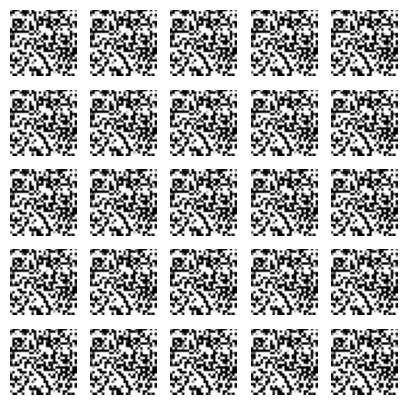

In [ ]:
# Train the GAN model
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(700):
    # Sample random noise from the latent space
    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))

    # Generate fake images using the generator
    fake_imgs = generator.predict(noise)

    # Select a random batch of real images
    idx = np.random.randint(0, len(img_data), batch_size)
    real_imgs = np.array([img_data[i] for i in idx])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = gan.train_on_batch(noise, valid)
    # Print the loss at each epoch
    print(f'Epoch {epoch+1}, D loss: {d_loss}, G loss: {g_loss}') # Indentation fixed to 4 spaces

# Save the trained generator model
generator.save('generator_model.h5')

# Use the trained generator to generate new images
noise = np.random.normal(0, 1, (25, LATENT_DIM))
generated_imgs = generator.predict(noise)

# Plot the generated images
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_imgs[i].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
    plt.axis('off')
plt.show()

